In [1]:
#import pixiedust

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)
#sns.set(rc={'figure.figsize':(12,8)})

# Reading data

In [3]:
data = pd.read_csv('winemag-data_first150k.csv',index_col=0)
data.sample(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
57407,US,You'll want to give this wine a little time in...,Botella,87,40.0,California,Sta. Rita Hills,Central Coast,Pinot Noir,Sea Smoke
102189,Argentina,"Clean, straightforward aromas of berry, cassis...",Saurus Patagonia Select,88,20.0,Other,Neuquén,NaN,Malbec,Familia Schroeder
94642,Uruguay,This blend of several grapes led by Tannat is ...,Preludio Barrel Select Lote Number 60,84,50.0,Juanico,NaN,NaN,Red Blend,Establecimiento Juanico
73557,France,Full-bodied and richly fruity wine. It has goo...,NaN,90,35.0,Provence,Côtes de Provence,NaN,Rosé,Château d'Esclans
85156,US,"The vintage was terribly difficult, with cold ...",NaN,82,28.0,California,Sonoma Coast,Sonoma,Pinot Noir,Roth


In [4]:
for c in data.columns:
    print(c,'='*(20-len(c)),data[c].unique().size)

country ============= 49
description ========= 97821
designation ========= 30622
points ============== 21
price =============== 358
province ============ 456
region_1 ============ 1237
region_2 ============ 19
variety ============= 632
winery ============== 14810


## Cleanup

In [5]:
# Drop columns that won't be used now
df = data.drop(columns=['description','designation','region_1','region_2','winery'])

In [6]:
# Keep only countries with more than 200 different wines
s = (df.country.value_counts()>200)
idx = s[s].index.tolist()
df = df[df.country.isin(idx)]

In [7]:
# Remove very expensive bottles
df = df[df.price<100]

In [8]:
for c in df.columns:
    print(c,'='*(20-len(c)),df[c].unique().size)

country ============= 15
points ============== 21
price =============== 96
province ============ 331
variety ============= 574


# Visualization

## Directly with pandas

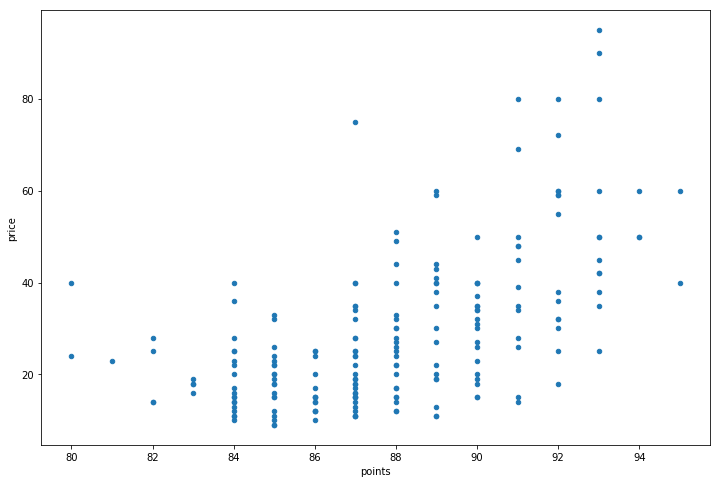

In [9]:
df.sample(200).plot.scatter(x='points',y='price');

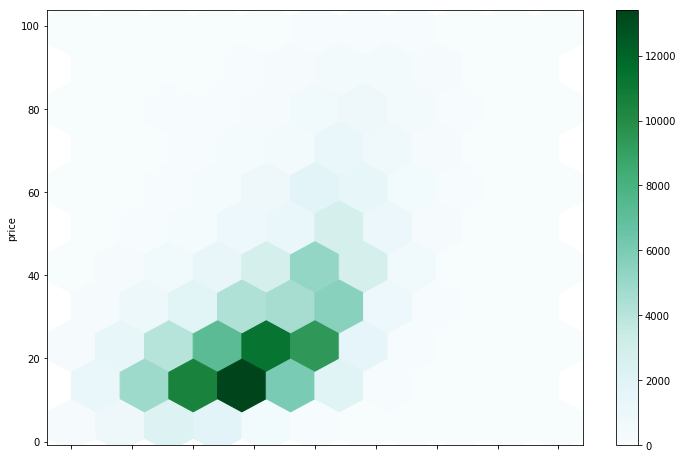

In [10]:
df.plot.hexbin(x='points',y='price',gridsize=10);

## Using Seaborn

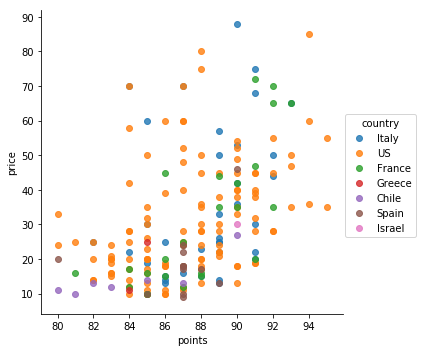

In [11]:
idx = df.country.isin(['US','France','Spain','Italy','Chile','Israel','Greece'])
sns.lmplot(x='points',y='price',data=df[idx].sample(200),
           fit_reg=False,
           hue='country',
           #hue_order=['France','US','Spain','Italy','Chile','Israel'],
           #palette='deep',
          );

# Machine Learning

In [12]:
from sklearn import tree, model_selection#, preprocessing

In [13]:
#le = preprocessing.LabelEncoder()
#le.fit_transform(y)

In [14]:
X = df[['country', 'price', 'province', 'variety']]
y = df['points']

## Splitting

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,train_size=0.8,random_state=123)
X_cv, X_test, y_cv, y_test = model_selection.train_test_split(X_test,y_test,train_size=0.5)

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
print(X_train.shape,X_cv.shape,X_test.shape,y_train.shape,y_cv.shape,y_test.shape)

(105613, 4) (13202, 4) (13202, 4) (105613,) (13202,) (13202,)


## Encoding

In [17]:
#### Encoder from Alex Gbx

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.ensemble.partial_dependence import partial_dependence

class ImpactEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, col=None, m = 100,  new_col=None, k_fold = 4):
        self.col = col
        self.m = m
        self.new_col = new_col

    def fit(self, X, y=None):
            counts = X[self.col].value_counts()
            frequency = counts.apply(lambda x: float(x)/(float(x) + self.m))
            encoded_mean = pd.concat([X , y] ,axis =1).groupby(self.col)[y.name].agg(np.mean)
            mean = y.mean()
            def project(x):
                try:
                    return encoded_mean.loc[x]*frequency.loc[x] + (1-frequency.loc[x])*mean
                except:
                    return mean
            self.__transform = lambda data: data[self.col].apply(project).to_frame(name = self.new_col)
            return self

    def transform(self, X):
        try:
            return self.__transform(X)
        except AttributeError:
            print(" not fitted")


    def stacked_transform(self, X, y, seed = 2018):
        k_fold = 4
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=seed)
        df_output = pd.DataFrame(columns = [self.col])
        for dev_index, val_index in kf.split(range(X.shape[0])):
                dev_X, val_X = X.iloc[dev_index,:], X.iloc[val_index,:]
                dev_y, val_y = y.iloc[dev_index], y.iloc[val_index]
                df_output = df_output.append(self.fit(dev_X, dev_y).transform(val_X))
        X = X.drop(self.col, axis = 1).join(df_output)
        return X

In [18]:
IEs = {}
for col in ['country', 'price', 'province', 'variety']:
    ie = ImpactEncoder(col=col).fit(X_train,y_train)
    IEs[col] = ie
    
IEs

{'country': ImpactEncoder(col='country', k_fold=None, m=100, new_col=None),
 'price': ImpactEncoder(col='price', k_fold=None, m=100, new_col=None),
 'province': ImpactEncoder(col='province', k_fold=None, m=100, new_col=None),
 'variety': ImpactEncoder(col='variety', k_fold=None, m=100, new_col=None)}

In [19]:
def apply_impact(IE_dict,X,y):
    Xtemp = X
    for ie in IE_dict.values():
        Xtemp = ie.stacked_transform(Xtemp,y)
    return Xtemp

In [20]:
X_train_impact = apply_impact(IEs,X_train,y_train)
X_test_impact = apply_impact(IEs,X_test,y_test)

In [21]:
X_train_impact.head()

,country,price,province,variety
96097,87.714243,89.057106,88.426491,88.568994
139066,85.979911,85.553460,86.119312,87.250153
30321,88.172411,86.242648,88.231202,87.958205
11489,87.702412,86.550670,86.210729,86.641986
62996,87.714243,88.133061,87.562006,87.554071


In [22]:
X_test_impact.head()

,country,price,province,variety
1641,87.924580,86.495779,87.546724,88.176669
19499,88.207408,86.878940,87.640337,87.735733
134305,87.987041,86.878940,87.757230,88.294973
105285,86.376703,85.912682,87.109822,86.623653
17866,87.758809,87.556435,87.590996,88.407930


## Modelling

In [23]:
model1 = tree.tree.DecisionTreeRegressor()
model1.fit(X_train_impact,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [24]:
X_hat1 = model1.predict(X_test_impact)
X_hat1

array([ 88. ,  84. ,  92. , ...,  87. ,  88. ,  89.5])

In [25]:
(y_test-X_hat1).round().abs().sum()/y_test.size

2.8122254203908499

## XGBoost

In [26]:
import xgboost

In [27]:
model2 = xgboost.XGBRegressor()
model2.fit(X_train_impact,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
X_hat2 = model2.predict(X_test_impact)
X_hat2

array([ 86.82587433,  87.00598907,  88.09391785, ...,  86.33821106,
        87.29152679,  87.07250977], dtype=float32)

In [29]:
(y_test-X_hat2).round().abs().sum()/y_test.size

2.0774125132555672

## CatBoost

In [30]:
from catboost import CatBoostRegressor

In [31]:
model3 = CatBoostRegressor()
model3.fit(X_train,y_train,cat_features=[0,1,2,3])

0:	learn: 85.0686079	total: 134ms	remaining: 2m 14s
1:	learn: 82.5203527	total: 223ms	remaining: 1m 51s
2:	learn: 80.0486319	total: 280ms	remaining: 1m 33s
3:	learn: 77.6510840	total: 328ms	remaining: 1m 21s
4:	learn: 75.3256254	total: 450ms	remaining: 1m 29s
5:	learn: 73.0700280	total: 518ms	remaining: 1m 25s
6:	learn: 70.8822001	total: 576ms	remaining: 1m 21s
7:	learn: 68.7600515	total: 622ms	remaining: 1m 17s
8:	learn: 66.7017379	total: 687ms	remaining: 1m 15s
9:	learn: 64.7052873	total: 803ms	remaining: 1m 19s
10:	learn: 62.7688479	total: 850ms	remaining: 1m 16s
11:	learn: 60.8906239	total: 894ms	remaining: 1m 13s
12:	learn: 59.0688733	total: 979ms	remaining: 1m 14s
13:	learn: 57.3019064	total: 1.05s	remaining: 1m 13s
14:	learn: 55.5880844	total: 1.14s	remaining: 1m 14s
15:	learn: 53.9258176	total: 1.23s	remaining: 1m 15s
16:	learn: 52.3135642	total: 1.29s	remaining: 1m 14s
17:	learn: 50.7498293	total: 1.33s	remaining: 1m 12s
18:	learn: 49.2331612	total: 1.38s	remaining: 1m 11s
19:

161:	learn: 2.5800236	total: 10.8s	remaining: 55.8s
162:	learn: 2.5735162	total: 10.9s	remaining: 55.9s
163:	learn: 2.5674212	total: 11s	remaining: 55.9s
164:	learn: 2.5617163	total: 11.1s	remaining: 56s
165:	learn: 2.5562331	total: 11.1s	remaining: 55.9s
166:	learn: 2.5510574	total: 11.2s	remaining: 55.7s
167:	learn: 2.5460776	total: 11.2s	remaining: 55.5s
168:	learn: 2.5415627	total: 11.2s	remaining: 55.3s
169:	learn: 2.5371092	total: 11.3s	remaining: 55.1s
170:	learn: 2.5329017	total: 11.3s	remaining: 55s
171:	learn: 2.5290626	total: 11.4s	remaining: 54.8s
172:	learn: 2.5253074	total: 11.4s	remaining: 54.6s
173:	learn: 2.5218792	total: 11.5s	remaining: 54.6s
174:	learn: 2.5184750	total: 11.7s	remaining: 55s
175:	learn: 2.5152735	total: 11.7s	remaining: 55s
176:	learn: 2.5123251	total: 11.8s	remaining: 54.9s
177:	learn: 2.5095683	total: 11.8s	remaining: 54.7s
178:	learn: 2.5066330	total: 11.9s	remaining: 54.5s
179:	learn: 2.5040468	total: 11.9s	remaining: 54.4s
180:	learn: 2.5016428	

322:	learn: 2.3887755	total: 21.3s	remaining: 44.7s
323:	learn: 2.3886129	total: 21.4s	remaining: 44.6s
324:	learn: 2.3883535	total: 21.4s	remaining: 44.5s
325:	learn: 2.3882230	total: 21.5s	remaining: 44.4s
326:	learn: 2.3881065	total: 21.5s	remaining: 44.3s
327:	learn: 2.3879206	total: 21.6s	remaining: 44.2s
328:	learn: 2.3878044	total: 21.7s	remaining: 44.2s
329:	learn: 2.3877364	total: 21.7s	remaining: 44.1s
330:	learn: 2.3876123	total: 21.8s	remaining: 44s
331:	learn: 2.3875012	total: 21.8s	remaining: 43.9s
332:	learn: 2.3873859	total: 21.9s	remaining: 43.8s
333:	learn: 2.3872618	total: 21.9s	remaining: 43.7s
334:	learn: 2.3869689	total: 22s	remaining: 43.6s
335:	learn: 2.3868446	total: 22s	remaining: 43.5s
336:	learn: 2.3866828	total: 22.1s	remaining: 43.4s
337:	learn: 2.3864186	total: 22.1s	remaining: 43.3s
338:	learn: 2.3863129	total: 22.2s	remaining: 43.2s
339:	learn: 2.3860898	total: 22.2s	remaining: 43.1s
340:	learn: 2.3859577	total: 22.3s	remaining: 43s
341:	learn: 2.385843

482:	learn: 2.3719641	total: 30.2s	remaining: 32.3s
483:	learn: 2.3719123	total: 30.2s	remaining: 32.2s
484:	learn: 2.3718527	total: 30.3s	remaining: 32.1s
485:	learn: 2.3718356	total: 30.3s	remaining: 32.1s
486:	learn: 2.3717610	total: 30.4s	remaining: 32s
487:	learn: 2.3717142	total: 30.5s	remaining: 32s
488:	learn: 2.3716131	total: 30.6s	remaining: 31.9s
489:	learn: 2.3714811	total: 30.6s	remaining: 31.9s
490:	learn: 2.3713893	total: 30.7s	remaining: 31.8s
491:	learn: 2.3713456	total: 30.7s	remaining: 31.7s
492:	learn: 2.3713001	total: 30.8s	remaining: 31.7s
493:	learn: 2.3712443	total: 30.8s	remaining: 31.6s
494:	learn: 2.3712048	total: 30.9s	remaining: 31.5s
495:	learn: 2.3711562	total: 30.9s	remaining: 31.4s
496:	learn: 2.3711191	total: 31s	remaining: 31.4s
497:	learn: 2.3710717	total: 31s	remaining: 31.3s
498:	learn: 2.3710207	total: 31.1s	remaining: 31.2s
499:	learn: 2.3709808	total: 31.1s	remaining: 31.1s
500:	learn: 2.3709241	total: 31.2s	remaining: 31.1s
501:	learn: 2.370871

641:	learn: 2.3632675	total: 39s	remaining: 21.8s
642:	learn: 2.3632063	total: 39.1s	remaining: 21.7s
643:	learn: 2.3631780	total: 39.1s	remaining: 21.6s
644:	learn: 2.3631323	total: 39.1s	remaining: 21.5s
645:	learn: 2.3630698	total: 39.2s	remaining: 21.5s
646:	learn: 2.3630170	total: 39.3s	remaining: 21.4s
647:	learn: 2.3629770	total: 39.4s	remaining: 21.4s
648:	learn: 2.3629436	total: 39.4s	remaining: 21.3s
649:	learn: 2.3629136	total: 39.5s	remaining: 21.2s
650:	learn: 2.3628433	total: 39.5s	remaining: 21.2s
651:	learn: 2.3627975	total: 39.6s	remaining: 21.1s
652:	learn: 2.3627423	total: 39.6s	remaining: 21s
653:	learn: 2.3626964	total: 39.6s	remaining: 21s
654:	learn: 2.3626334	total: 39.7s	remaining: 20.9s
655:	learn: 2.3625609	total: 39.7s	remaining: 20.8s
656:	learn: 2.3625237	total: 39.8s	remaining: 20.8s
657:	learn: 2.3624838	total: 39.8s	remaining: 20.7s
658:	learn: 2.3624384	total: 39.9s	remaining: 20.6s
659:	learn: 2.3623933	total: 39.9s	remaining: 20.6s
660:	learn: 2.3623

803:	learn: 2.3562669	total: 47.7s	remaining: 11.6s
804:	learn: 2.3562367	total: 47.8s	remaining: 11.6s
805:	learn: 2.3562146	total: 47.8s	remaining: 11.5s
806:	learn: 2.3561966	total: 47.9s	remaining: 11.4s
807:	learn: 2.3561247	total: 48.1s	remaining: 11.4s
808:	learn: 2.3560899	total: 48.2s	remaining: 11.4s
809:	learn: 2.3560631	total: 48.2s	remaining: 11.3s
810:	learn: 2.3560331	total: 48.2s	remaining: 11.2s
811:	learn: 2.3559910	total: 48.3s	remaining: 11.2s
812:	learn: 2.3559640	total: 48.3s	remaining: 11.1s
813:	learn: 2.3559264	total: 48.4s	remaining: 11.1s
814:	learn: 2.3559053	total: 48.4s	remaining: 11s
815:	learn: 2.3558695	total: 48.5s	remaining: 10.9s
816:	learn: 2.3558349	total: 48.5s	remaining: 10.9s
817:	learn: 2.3558025	total: 48.6s	remaining: 10.8s
818:	learn: 2.3557618	total: 48.6s	remaining: 10.7s
819:	learn: 2.3557427	total: 48.6s	remaining: 10.7s
820:	learn: 2.3556492	total: 48.7s	remaining: 10.6s
821:	learn: 2.3555826	total: 48.7s	remaining: 10.6s
822:	learn: 2.

963:	learn: 2.3512001	total: 55.5s	remaining: 2.07s
964:	learn: 2.3511733	total: 55.5s	remaining: 2.01s
965:	learn: 2.3511246	total: 55.6s	remaining: 1.96s
966:	learn: 2.3510963	total: 55.6s	remaining: 1.9s
967:	learn: 2.3510747	total: 55.7s	remaining: 1.84s
968:	learn: 2.3510672	total: 55.7s	remaining: 1.78s
969:	learn: 2.3510126	total: 55.8s	remaining: 1.72s
970:	learn: 2.3509862	total: 55.8s	remaining: 1.67s
971:	learn: 2.3509533	total: 55.9s	remaining: 1.61s
972:	learn: 2.3509188	total: 55.9s	remaining: 1.55s
973:	learn: 2.3508907	total: 55.9s	remaining: 1.49s
974:	learn: 2.3508475	total: 56s	remaining: 1.44s
975:	learn: 2.3508371	total: 56s	remaining: 1.38s
976:	learn: 2.3508028	total: 56.1s	remaining: 1.32s
977:	learn: 2.3507721	total: 56.1s	remaining: 1.26s
978:	learn: 2.3507463	total: 56.2s	remaining: 1.2s
979:	learn: 2.3507305	total: 56.2s	remaining: 1.15s
980:	learn: 2.3506872	total: 56.2s	remaining: 1.09s
981:	learn: 2.3506440	total: 56.3s	remaining: 1.03s
982:	learn: 2.3506

In [32]:
X_hat3 = model3.predict(X_test)
X_hat3

array([ 87.90755367,  87.56441567,  88.21906905, ...,  84.86124009,
        87.31710838,  88.61384968])

In [33]:
(y_test-X_hat3).round().abs().sum()/y_test.size

1.8168459324344797